In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import plotly.express as px
from scipy.optimize import curve_fit
from scipy import stats
from scipy.signal import find_peaks, lombscargle, butter, filtfilt
import plotly.graph_objects as go


/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [5]:
df = pd.read_csv("data/Sanjay/green/30_apr_sanjay_3.csv")
print(df)
df['time (sec)'] = df['0'] / 1000
df['neg_amplitude'] = -1*df['676']

sample_rate = 1/np.mean(np.diff(df['time (sec)']))
nyq = sample_rate/2
order=4
low_cutoff= 5
high_cutoff = 0.5
low_normal_cutoff = low_cutoff/nyq
high_normal_cutoff = high_cutoff/nyq
high_b, high_a = butter(order, high_normal_cutoff, btype='highpass')
low_b, low_a = butter(order, low_normal_cutoff, btype='lowpass')

df['filtered_amp'] = filtfilt(high_b, high_a, filtfilt(low_b, low_a, df['676']))
df['neg_filtered_amp'] = -1*df['filtered_amp']

y_col = 'filtered_amp'
neg_col = 'neg_filtered_amp'

peaks = find_peaks(df[y_col], prominence=4, distance=30)
neg_peaks = find_peaks(df[neg_col], prominence=4, distance=30)

dicrotic_peaks = find_peaks(df[y_col], prominence=0.20, distance=10)
dicrotic_peaks = dicrotic_peaks[0][~np.isin(dicrotic_peaks[0], peaks[0])]

neg_dicrotic_peaks = find_peaks(df[neg_col], prominence=0.20, distance=10)
neg_dicrotic_peaks = neg_dicrotic_peaks[0][~np.isin(neg_dicrotic_peaks[0], neg_peaks[0])]


          0  676  109  81  90
0         0  674  NaN NaN NaN
1         1  674  NaN NaN NaN
2         1  674  NaN NaN NaN
3         1  673  NaN NaN NaN
4         2  674  NaN NaN NaN
...     ...  ...  ...  ..  ..
3515  38986  666  NaN NaN NaN
3516  38998  666  NaN NaN NaN
3517  39009  666  NaN NaN NaN
3518  39020  666  NaN NaN NaN
3519  39031  666  NaN NaN NaN

[3520 rows x 5 columns]


In [6]:
fig = px.line(df, x='time (sec)', y=y_col)

for i in range(len(peaks[0])):
    fig.add_trace(go.Scatter(
    x=[df['time (sec)'].iloc[peaks[0][i]]],
    y=[df[y_col].iloc[peaks[0][i]]],
    mode='markers',
    marker=dict(color='black', size=8),
))
    
for i in range(len(neg_peaks[0])):
    fig.add_trace(go.Scatter(
    x=[df['time (sec)'].iloc[neg_peaks[0][i]]],
    y=[df[y_col].iloc[neg_peaks[0][i]]],
    mode='markers',
    marker=dict(color='red', size=8),
)) 
    
for i in range(len(dicrotic_peaks)):
    fig.add_trace(go.Scatter(
    x=[df['time (sec)'].iloc[dicrotic_peaks[i]]],
    y=[df[y_col].iloc[dicrotic_peaks[i]]],
    mode='markers',
    marker=dict(color='green', size=8),
)) 
        
for i in range(len(neg_dicrotic_peaks)):
    fig.add_trace(go.Scatter(
    x=[df['time (sec)'].iloc[neg_dicrotic_peaks[i]]],
    y=[df[y_col].iloc[neg_dicrotic_peaks[i]]],
    mode='markers',
    marker=dict(color='purple', size=8),
)) 
    
fig.update_layout(showlegend=False)
fig.show()


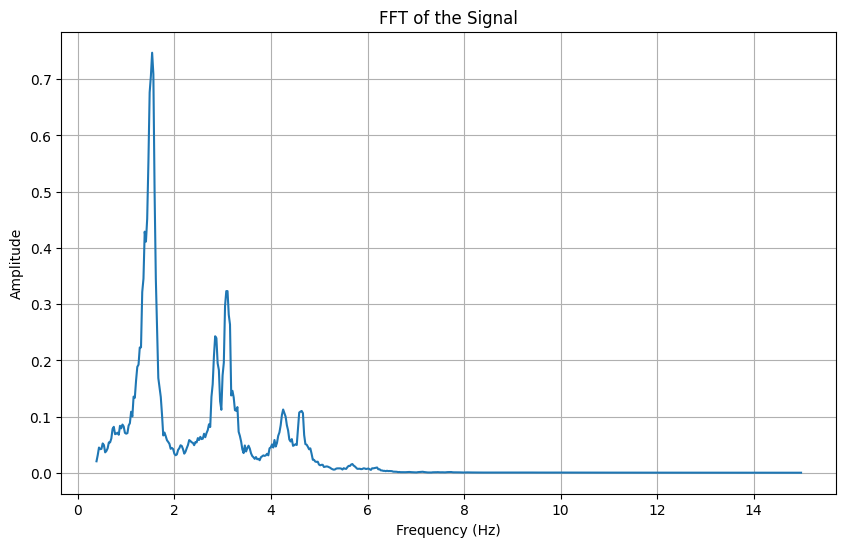

In [10]:
# Calculate the time step (assuming uniform spacing)
time = df['time (sec)'].values
amplitude = df['filtered_amp'].values
dt = np.mean(np.diff(time))  # or use np.mean(np.diff(time)) if it's not perfectly uniform

# Compute FFT
N = len(amplitude)
yf = fft(amplitude)
xf = fftfreq(N, dt)[:N//2]  # Take the positive half of the frequencies
amplitude_spectrum = 2.0/N * np.abs(yf[:N//2])

# Define frequency slice
start = 15
end = int(len(xf) / 3)

# Smooth using moving average
def moving_average(x, w):
    return np.convolve(x, np.ones(w), mode='same') / w

smoothed_amplitude = moving_average(amplitude_spectrum, w=5)  # Adjust window size as needed
smoothed_amplitude = smoothed_amplitude[start:end]
xf = xf[start:end]
# Plot FFT
plt.figure(figsize=(10, 6))
plt.plot(xf, smoothed_amplitude)
plt.title("FFT of the Signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

Gaussian BPM: 89.426
Lorentzian BPM: 90.065
Simple Max: 92.20817485402048
3.8434655433416998 1.0


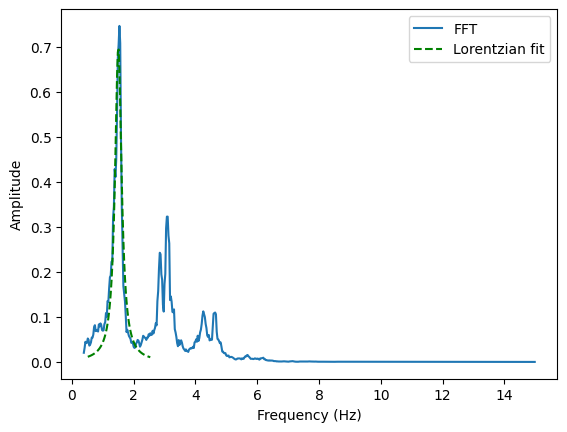

In [8]:
peak_idx = np.argmax(smoothed_amplitude)
peak_freq = xf[peak_idx]

# Window around peak
window = 40  # number of points on each side
start_window = max(peak_idx - window, 0)
end_window = min(peak_idx + window, len(xf))
fit_freqs = xf[start_window:end_window]
fit_vals = smoothed_amplitude[start_window:end_window]
# Gaussian model
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def lorentzian(x, a, x0, gamma):
    return a / (1 + ((x - x0) / gamma)**2)

# Initial guesses
a0 = np.max(fit_vals)
x0 = fit_freqs[np.argmax(fit_vals)]
sigma0 = (fit_freqs[-1] - fit_freqs[0]) / 6

popt, _ = curve_fit(gaussian, fit_freqs, fit_vals, p0=[a0, x0, sigma0])
_, peak_gaussian, _ = popt

popt_l, _ = curve_fit(lorentzian, fit_freqs, fit_vals)
_, peak_lorentzian, _ = popt_l

print(f"Gaussian BPM: {peak_gaussian*60:.3f}")
print(f"Lorentzian BPM: {peak_lorentzian*60:.3f}")
print(f"Simple Max: {xf[peak_idx] * 60}")
plt.plot(xf, smoothed_amplitude, label='FFT')

chi2 = np.sum((smoothed_amplitude[start_window:end_window] - lorentzian(fit_freqs, *popt_l))**2/lorentzian(fit_freqs, *popt_l))
dof = len(smoothed_amplitude[start_window:end_window]) - len(popt_l)
pvalue =  1 - stats.chi2.cdf(chi2, dof)

print(chi2, pvalue)
# plt.plot(fit_freqs, gaussian(fit_freqs, *popt), 'r--', label='Gaussian fit')
plt.plot(fit_freqs, lorentzian(fit_freqs, *popt_l), 'g--', label='Lorentzian fit')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

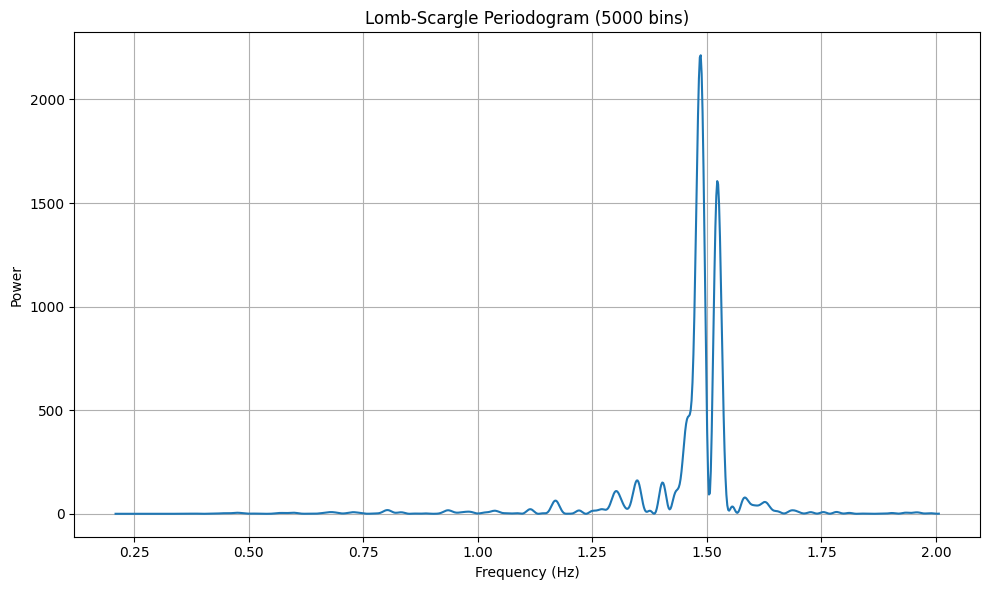

In [9]:
# Detrend the signal (optional but usually helpful)
amplitude = amplitude - np.mean(amplitude)

# Define frequency range
f_min = 0.01  # Hz, adjust based on your data
f_max = 10    # Hz, or something like 1 / min(np.diff(time)) if unsure

# Convert to angular frequencies (radians/second)
frequencies = np.linspace(f_min, f_max, 5000)
angular_freqs = 2 * np.pi * frequencies

# Compute Lomb-Scargle periodogram
power = lombscargle(time, amplitude, angular_freqs)

start = 100
end = 1000
# Plot
plt.figure(figsize=(10, 6))
plt.plot(frequencies[start:end], power[start:end])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram (5000 bins)")
plt.grid(True)
plt.tight_layout()
plt.show()